# 멤버십 서비스의 MRR(Monthly Recurring Revenue) 계산

작성일자 : 2024-02-06

작성자 : 민희수

### **Problem**
멤버십 서비스 데이터를 활용하여 멤버십 서비스의 MRR(Monthly Recurring Revenue)를 구하고, 결과를 확인합니다.
### **Process**
1. 데이터셋 확인
2. Data Cleansing
3. EDA
4. Visualizing the Data
5. MRR 계산
6. Charting the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

import warnings
warnings.filterwarnings('ignore')

### 1. 데이터셋 확인

In [ ]:
# 데이터 가져오기
df = pd.read_csv('/content/gdrive/My Drive/data/membership_data.csv')

print(df.shape)
df.head()

(1768, 5)


,store_id,start_date,end_date,membership_type,price
0,9,2023-04-01,2023-04-30,Premium,20000
1,12,2023-04-01,2023-04-30,Premium,20000
2,16,2023-04-01,2023-04-30,Premium,20000
3,27,2023-04-01,2023-04-30,Premium,20000
4,59,2023-04-03,2023-05-02,Premium,20000


### 2. Data Cleansing

In [ ]:
# Change object to datetime
df['start_date'] = pd.to_datetime(df.start_date)
df['end_date'] = pd.to_datetime(df.end_date)

In [ ]:
# 이전 월의 멤버십 정보를 저장할 컬럼 추가
df.sort_values(by=['store_id', 'start_date'], inplace=True)
df['previous_membership_type'] = df.groupby('store_id')['membership_type'].shift(1)
df['store_id_index'] = df.groupby('store_id')['start_date'].rank(method='first').astype(int)

In [ ]:
# 멤버십 기간을 저장할 컬럼 추가
df['membership_duration'] = (df['end_date'] - df['start_date']).dt.days + 1

In [ ]:
# 일자별 금액을 저장할 컬럼 추가
df['price_per_day'] = 0

In [ ]:
# 필요한 컬럼 추가
df['start_weekday'] = df['start_date'].dt.day_name()
df['end_weekday'] = df['end_date'].dt.day_name()

In [ ]:
df.head()

,store_id,start_date,end_date,membership_type,price,previous_membership_type,store_id_index,membership_duration,price_per_day,start_weekday,end_weekday
0,9,2023-04-01,2023-04-30,Premium,20000,NaN,1,30,0,Saturday,Sunday
219,9,2023-10-12,2023-11-11,Premium,20000,Premium,2,31,0,Thursday,Saturday
578,9,2023-11-12,2023-12-11,Premium,20000,Premium,3,30,0,Sunday,Monday
441,9,2023-12-12,2024-01-13,Premium,20000,Premium,4,33,0,Tuesday,Saturday
1282,10,2023-04-01,2023-04-30,Premium,20000,NaN,1,30,0,Saturday,Sunday


### 3. EDA

In [ ]:
# 데이터 컬럼 확인
df.columns

Index(['store_id', 'start_date', 'end_date', 'membership_type', 'price',
       'previous_membership_type', 'store_id_index', 'membership_duration',
       'price_per_day', 'start_weekday', 'end_weekday'],
      dtype='object')

In [ ]:
# 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768 entries, 0 to 1650
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   store_id                  1768 non-null   int64         
 1   start_date                1768 non-null   datetime64[ns]
 2   end_date                  1768 non-null   datetime64[ns]
 3   membership_type           1768 non-null   object        
 4   price                     1768 non-null   int64         
 5   previous_membership_type  1177 non-null   object        
 6   store_id_index            1768 non-null   int64         
 7   membership_duration       1768 non-null   int64         
 8   price_per_day             1768 non-null   int64         
 9   start_weekday             1768 non-null   object        
 10  end_weekday               1768 non-null   object        
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 165.8+ KB


In [ ]:
# 결측치 확인
df.isna().sum()

store_id                      0
start_date                    0
end_date                      0
membership_type               0
price                         0
previous_membership_type    591
store_id_index                0
membership_duration           0
price_per_day                 0
start_weekday                 0
end_weekday                   0
dtype: int64

In [ ]:
# 중복 확인
df.nunique()

store_id                    591
start_date                  235
end_date                    234
membership_type               2
price                         2
previous_membership_type      2
store_id_index                9
membership_duration           3
price_per_day                 1
start_weekday                 7
end_weekday                   7
dtype: int64

In [ ]:
# 가격 분포 확인
df['price'].value_counts()

20000    1417
10000     351
Name: price, dtype: int64

In [ ]:
# 멤버십 기간 분포 확인
df['membership_duration'].describe()

count    1768.000000
mean       30.889140
std         1.053807
min        30.000000
25%        30.000000
50%        31.000000
75%        31.000000
max        33.000000
Name: membership_duration, dtype: float64

In [ ]:
# 가격과 멤버십 기간 간의 관계 확인
df.groupby('membership_type').agg({'price':'mean', 'membership_duration':'mean'})

,price,membership_duration
membership_type,,
Basic,10000.0,30.903134
Premium,20000.0,30.885674


In [ ]:
# 데이터 통계 요약
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
store_id,1768.0,NaN,NaN,NaN,NaT,NaT,255.259615,158.888609,9.0,130.0,225.0,367.25,628.0
start_date,1768,235,2023-08-21 00:00:00,32,2023-04-01,2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,1768,234,2023-09-20 00:00:00,32,2023-04-30,2024-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
membership_type,1768,2,Premium,1417,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1768.0,NaN,NaN,NaN,NaT,NaT,18014.705882,3990.056802,10000.0,20000.0,20000.0,20000.0,20000.0
previous_membership_type,1177,2,Premium,983,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_id_index,1768.0,NaN,NaN,NaN,NaT,NaT,2.774321,1.902989,1.0,1.0,2.0,4.0,9.0
membership_duration,1768.0,NaN,NaN,NaN,NaT,NaT,30.88914,1.053807,30.0,30.0,31.0,31.0,33.0
price_per_day,1768.0,NaN,NaN,NaN,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
start_weekday,1768,7,Monday,330,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4. Visualizing the Data

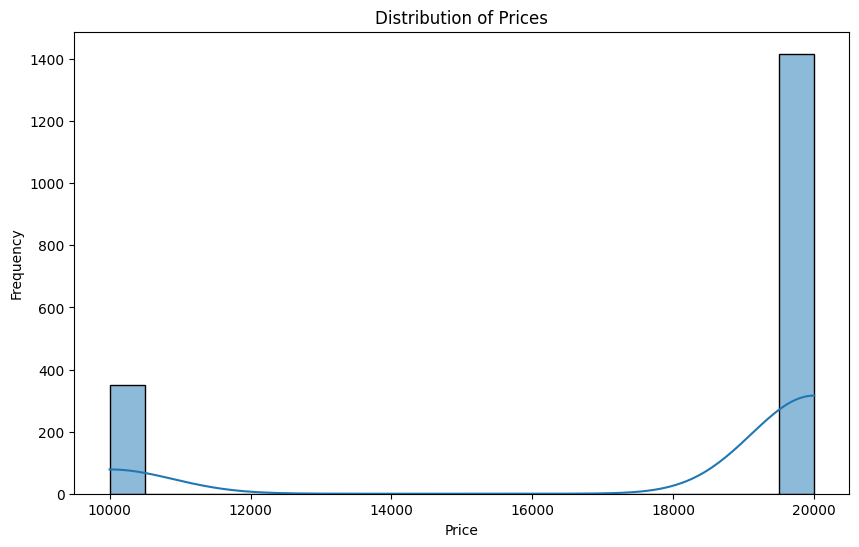

In [ ]:
# 가격 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=20, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

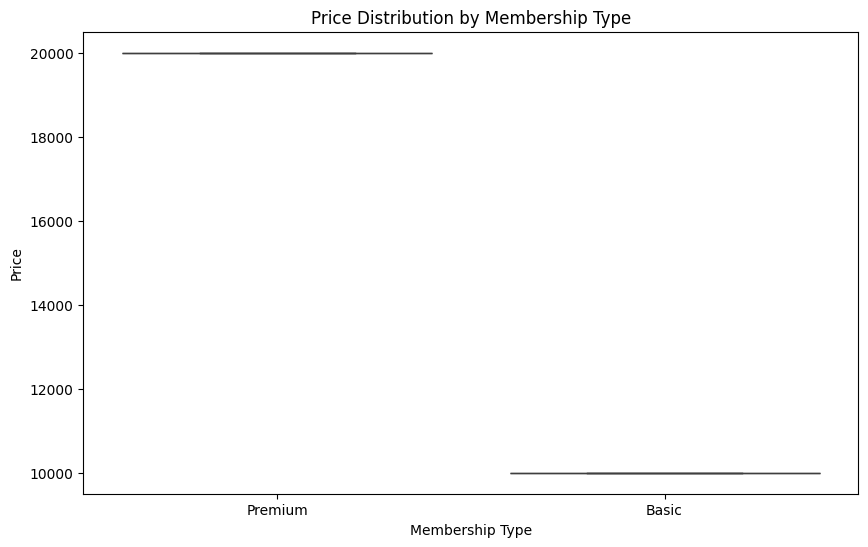

In [ ]:
# 멤버십 유형별 가격 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='membership_type', y='price', data=df)
plt.title('Price Distribution by Membership Type')
plt.xlabel('Membership Type')
plt.ylabel('Price')
plt.show()

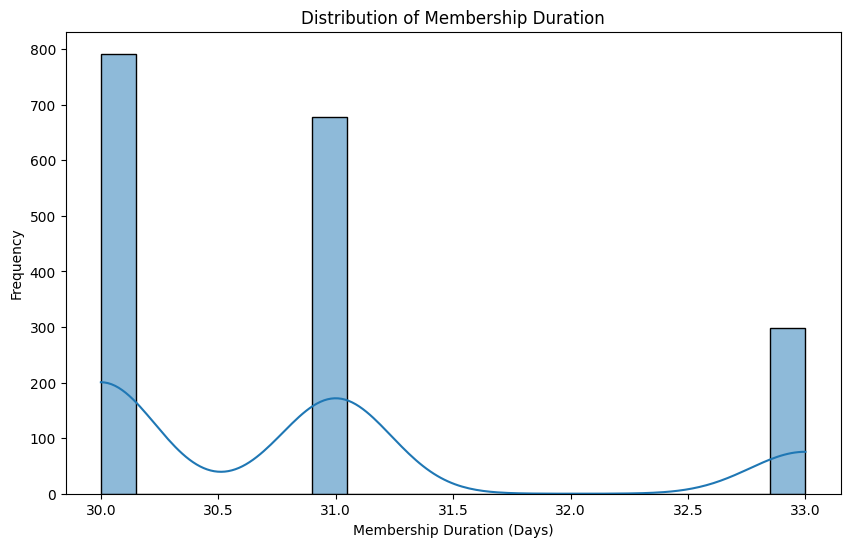

In [ ]:
# 멤버십 기간 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df['membership_duration'], bins=20, kde=True)
plt.title('Distribution of Membership Duration')
plt.xlabel('Membership Duration (Days)')
plt.ylabel('Frequency')
plt.show()

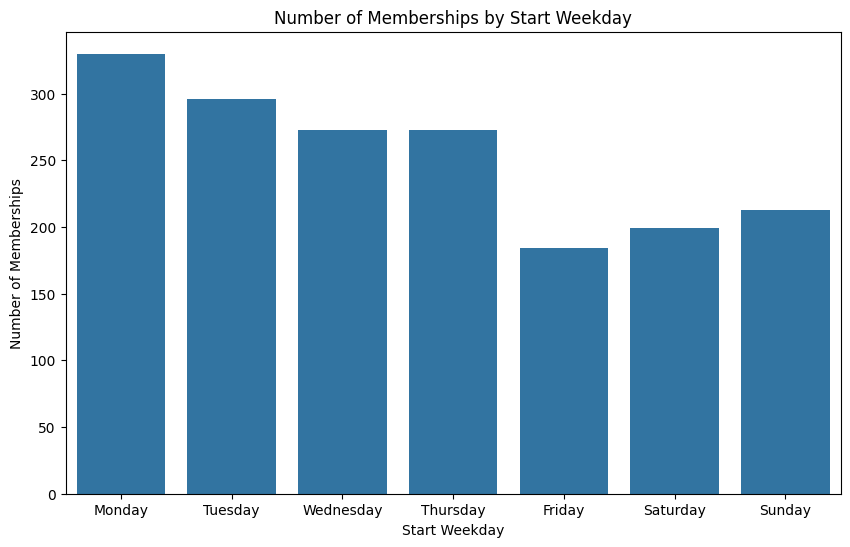

In [ ]:
# 요일별 멤버십 가입자 수 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='start_weekday', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Memberships by Start Weekday')
plt.xlabel('Start Weekday')
plt.ylabel('Number of Memberships')
plt.show()

### 5. MRR 계산
- **new MRR** : 신규 사용자로부터 발생한 MRR
  - 기준 : 해당 월의 시작일 또는 종료일이 속하는 사용자 중, 해당 store_id에 대해 이전에 발생한 적이 없는 경우
- **expansion MRR** : 기존 사용자로부터 추가로 발생한 MRR (멤버십 업그레이드 Basic → Premium)
  - 기준 : 해당 월의 시작일 또는 종료일이 속하는 사용자 중, 기존 멤버십이 Basic에서 Premium으로 업그레이드된 경우
- **contraction MRR** : 기존 사용자로부터 감소한 MRR (멤버십 다운그레이드 Premium → Basic)
  - 기준 : 해당 월의 시작일 또는 종료일이 속하는 사용자 중, 기존 멤버십이 Premium에서 Basic으로 다운그레이드된 경우
- **reactivation MRR** : 복귀 사용자로부터 발생한 MRR
  - 기준 : 해당 월의 시작일 또는 종료일이 속하는 사용자 중, 해당 store_id에 대해 이전에 발생한 적이 있는 경우
- **churn MRR** : 사용자의 이탈로 인해 감소한 MRR
  - 기준 : 해당 월 이전의 종료일에 속하는 사용자 중, 해당 월에 재가입하지 않은 경우
- **net MRR** : 순 MRR
  - 기준 : new MRR + expansion MRR - churn MRR

In [ ]:
start_date = datetime(2023, 4, 1)
end_date = datetime(2023, 12, 1)

date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
mrr_df = pd.DataFrame(index=date_range, columns=['month', 'MRR', 'new_MRR', 'expansion_MRR', 'contraction_MRR', 'reactivation_MRR', 'churn_MRR_all', 'churn_MRR'])

mrr_df['month'] = pd.to_datetime(mrr_df.month)

In [ ]:
def calculate_price_per_day(user):
    if user['store_id'] != user['store_id']:
      return 0
    else:
      start_date = user['start_date']
      end_date = user['end_date']
      price = user['price']
      membership_duration = user['membership_duration']

      day_price = price / membership_duration

      if start_date.month != end_date.month:
          month_days = end_date.day if start_date.month != month else (calendar.monthrange(year, month)[1] - end_date.day) + 1
      else:
          month_days = membership_duration

      return round(day_price * month_days)

In [ ]:
def calculate_mrr(users):
    return users['price_per_day'].sum().astype(int)

In [ ]:
for date in date_range:
    year = date.year
    month = date.month
    day = date.day

    print(f'[ {year}년 {month}월 ]')

    # 해당 월의 총 사용자
    previous_users = df[(df['start_date'].dt.month <= month-1) & (df['end_date'].dt.month <= month) & (df['end_date'].dt.year == year)]
    month_users = df[(df['start_date'].dt.month == month) | (df['end_date'].dt.month == month)]
    month_users['price_per_day'] = month_users.apply(calculate_price_per_day, axis=1)
    print(f'총 사용자 : {month_users.shape[0]}명')

    # 해당 월에 신규 가입한 사용자
    new_users = month_users[month_users['store_id_index'] == 1]
    new_users['price_per_day'] = new_users.apply(calculate_price_per_day, axis=1)
    print(f'신규 가입한 사용자 : {new_users.shape[0]}명')

    # 해당 월에 복귀한 사용자
    reactivated_users = month_users[month_users['store_id_index'] != 1]
    reactivated_users['price_per_day'] = reactivated_users.apply(calculate_price_per_day, axis=1)
    print(f'복귀한 사용자 : {reactivated_users.shape[0]}명')

    # 해당 월에 이탈한 사용자
    churned_users = df[(df['end_date'].dt.month <= month-1) & (df['end_date'].dt.year == year)]
    churned_users = churned_users[~churned_users['store_id'].isin(month_users['store_id'])]
    churned_users['price_per_day'] = churned_users.apply(calculate_price_per_day, axis=1)
    print(f'이탈한 사용자 : {churned_users.shape[0]}명')

    # 해당 월에 Basic에서 Premium으로 업그레이드 한 사용자
    upgraded_users = month_users[(month_users['membership_type'] == 'Premium') & (month_users['previous_membership_type'] == 'Basic')]
    upgraded_users['price_per_day'] = upgraded_users.apply(calculate_price_per_day, axis=1)
    print(f'업그레이드한 사용자 : {upgraded_users.shape[0]}명')

    # 해당 월에 Premium에서 Basic으로 다운그레이드 한 사용자
    downgraded_users = month_users[(month_users['membership_type'] == 'Basic') & (month_users['previous_membership_type'] == 'Premium')]
    downgraded_users['price_per_day'] = downgraded_users.apply(calculate_price_per_day, axis=1)
    print(f'다운그레이드한 사용자 : {downgraded_users.shape[0]}명')

    # MRR 지표 계산
    mrr = calculate_mrr(month_users)
    new_mrr = calculate_mrr(new_users)
    expansion_mrr = calculate_mrr(upgraded_users)
    contraction_mrr = calculate_mrr(downgraded_users)
    reactivation_mrr = calculate_mrr(reactivated_users)
    churn_mrr_all = calculate_mrr(churned_users)

    filtered_df = mrr_df[mrr_df['month'] < date]
    if not filtered_df.empty:
      churn_mrr_before_target = mrr_df[mrr_df['month'] < date]['churn_MRR_all'].iloc[-1]
    else:
      churn_mrr_before_target = 0
    churn_mrr = calculate_mrr(churned_users) - churn_mrr_before_target

    mrr_df.loc[date] = [date, mrr, new_mrr, expansion_mrr, contraction_mrr, reactivation_mrr, churn_mrr_all, churn_mrr]

    print('-----------------------------------------------')

mrr_df

[ 2023년 4월 ]
총 사용자 : 104명
신규 가입한 사용자 : 104명
복귀한 사용자 : 0명
이탈한 사용자 : 0명
업그레이드한 사용자 : 0명
다운그레이드한 사용자 : 0명
-----------------------------------------------
[ 2023년 5월 ]
총 사용자 : 167명
신규 가입한 사용자 : 121명
복귀한 사용자 : 46명
이탈한 사용자 : 13명
업그레이드한 사용자 : 0명
다운그레이드한 사용자 : 4명
-----------------------------------------------
[ 2023년 6월 ]
총 사용자 : 136명
신규 가입한 사용자 : 40명
복귀한 사용자 : 96명
이탈한 사용자 : 63명
업그레이드한 사용자 : 0명
다운그레이드한 사용자 : 10명
-----------------------------------------------
[ 2023년 7월 ]
총 사용자 : 155명
신규 가입한 사용자 : 40명
복귀한 사용자 : 115명
이탈한 사용자 : 88명
업그레이드한 사용자 : 2명
다운그레이드한 사용자 : 8명
-----------------------------------------------
[ 2023년 8월 ]
총 사용자 : 261명
신규 가입한 사용자 : 105명
복귀한 사용자 : 156명
이탈한 사용자 : 95명
업그레이드한 사용자 : 10명
다운그레이드한 사용자 : 4명
-----------------------------------------------
[ 2023년 9월 ]
총 사용자 : 413명
신규 가입한 사용자 : 176명
복귀한 사용자 : 237명
이탈한 사용자 : 108명
업그레이드한 사용자 : 11명
다운그레이드한 사용자 : 6명
-----------------------------------------------
[ 2023년 10월 ]
총 사용자 : 582명
신규 가입한 사용자 : 213명
복귀한 사용자 : 369명
이탈한 사용자 : 131명
업그레이

,month,MRR,new_MRR,expansion_MRR,contraction_MRR,reactivation_MRR,churn_MRR_all,churn_MRR
2023-04-01,2023-04-01,1733661,1733661,0,0,0,0,0
2023-05-01,2023-05-01,1290370,542625,0,31290,747745,240000,240000
2023-06-01,2023-06-01,1255471,499950,0,42333,755521,492666,252666
2023-07-01,2023-07-01,1563868,414191,35484,39345,1149677,694664,201998
2023-08-01,2023-08-01,2261521,766555,93547,20322,1494966,786492,91828
2023-09-01,2023-09-01,4281072,2086350,102753,29623,2194722,831676,45184
2023-10-01,2023-10-01,5512471,1631704,191506,67226,3880767,1052577,220901
2023-11-01,2023-11-01,6461423,1804487,165568,91024,4656936,1346584,294007
2023-12-01,2023-12-01,5776929,1063002,91940,141038,4713927,2530741,1184157


In [ ]:
# Net MRR : New MRR + Expansion MRR - Churn MRR
mrr_df['net_MRR'] = mrr_df['new_MRR'] + mrr_df['expansion_MRR'] - mrr_df['churn_MRR']

In [ ]:
mrr_df

,month,MRR,new_MRR,expansion_MRR,contraction_MRR,reactivation_MRR,churn_MRR_all,churn_MRR,net_MRR
2023-04-01,2023-04-01,1733661,1733661,0,0,0,0,0,1733661
2023-05-01,2023-05-01,1290370,542625,0,31290,747745,240000,240000,302625
2023-06-01,2023-06-01,1255471,499950,0,42333,755521,492666,252666,247284
2023-07-01,2023-07-01,1563868,414191,35484,39345,1149677,694664,201998,247677
2023-08-01,2023-08-01,2261521,766555,93547,20322,1494966,786492,91828,768274
2023-09-01,2023-09-01,4281072,2086350,102753,29623,2194722,831676,45184,2143919
2023-10-01,2023-10-01,5512471,1631704,191506,67226,3880767,1052577,220901,1602309
2023-11-01,2023-11-01,6461423,1804487,165568,91024,4656936,1346584,294007,1676048
2023-12-01,2023-12-01,5776929,1063002,91940,141038,4713927,2530741,1184157,-29215


### 6. Charting the data

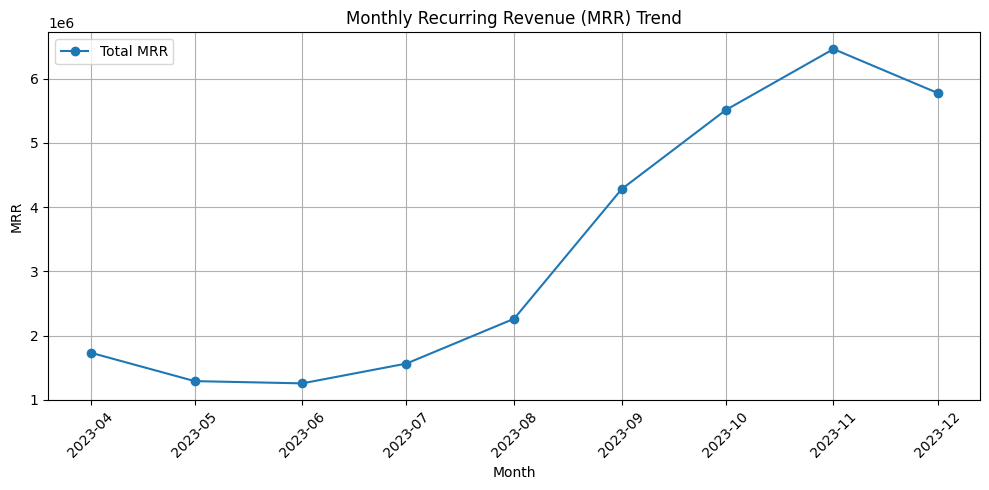

In [ ]:
# 월별 MRR 추세 그래프
plt.figure(figsize=(10, 5))
plt.plot(mrr_df['month'], mrr_df['MRR'], marker='o', label='Total MRR')
plt.title('Monthly Recurring Revenue (MRR) Trend')
plt.xlabel('Month')
plt.ylabel('MRR')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output_chart1.png')
plt.show()

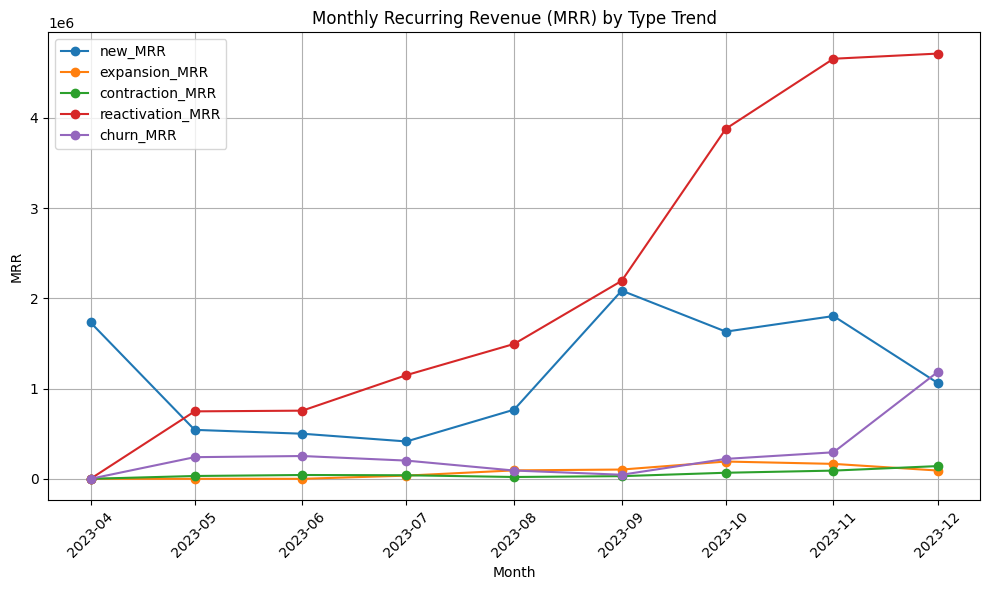

In [ ]:
# 각 유형의 MRR 추세 그래프
types = ['new_MRR', 'expansion_MRR', 'contraction_MRR', 'reactivation_MRR', 'churn_MRR']
plt.figure(figsize=(10, 6))
for mrr_type in types:
    plt.plot(mrr_df['month'], mrr_df[mrr_type], marker='o', label=mrr_type)
plt.title('Monthly Recurring Revenue (MRR) by Type Trend')
plt.xlabel('Month')
plt.ylabel('MRR')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output_chart2.png')
plt.show()

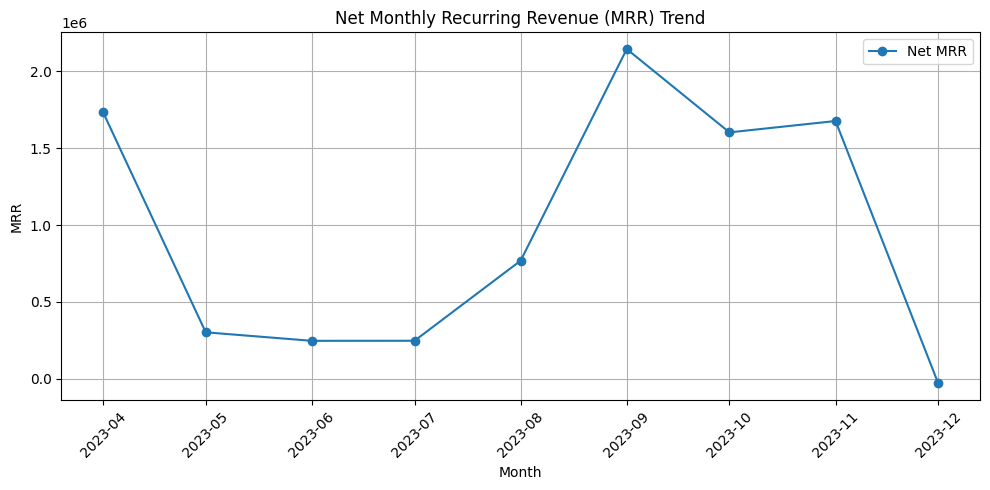

In [ ]:
# 월별 순MRR 추세 그래프
plt.figure(figsize=(10, 5))
plt.plot(mrr_df['month'], mrr_df['net_MRR'], marker='o', label='Net MRR')
plt.title('Net Monthly Recurring Revenue (MRR) Trend')
plt.xlabel('Month')
plt.ylabel('MRR')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output_chart3.png')
plt.show()